# hyperspectral-images: spectral unmixing & classification

> **Assignee** <br />
> full name: Antonopoulos Ilias <br />
> email: iantonopoulos@aueb.gr <br />
> ID: P3352004 <br />
> course: Machine Learning and Computational Statistics (M36104P) <br />
> program: MSc in Data Science (PT)

# Table of Contents

- [Reproducibility]()
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Spectral Unmixing](#Spectral-Unmixing)
 - [Least Squares with no constraints](#(a)-Least-Squares,-with-no-constraints)
 - [Least Squares with a sum-to-one constraint](#(b)-Least-Squares,-with-a-sum-to-one-constraint)
 - [Least Squares with a non-negativity constraint](#(c)-Least-Squares,-with-a-non-negativity-constraint)
 - [Least Squares with sum-to-one & non-negativity constraints](#(d)-Least-Squares,-with-sum-to-one-&-non-negativity-constraints)
 - [LASSO](#(e)-LASSO)
 - [Comparison and remarks]()
- [Classification](#Classification)
- [Combination]()

# Reproducibility

To easily reproduce the results of this Jupyter notebook, in a clean & efficient manner, do read the following:

Assuming that a [Python](https://www.python.org/) (v3.6.x or greater) is installed in your system:

- you could (optionally) upgrade `pip`:

```shell
python -m pip install --upgrade pip
```

- you could install all the necessary dependencies: 


**note**: the usage of a [virtual environment](https://docs.python.org/3/tutorial/venv.html#creating-virtual-environments) for this is highly advised, in order to keep your system-wide Python interpreter clean of unnecessary dependencies such as `scikit-learn` etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.optimize 

## Exploratory Data Analysis

We'll begin by loading all the available data, trying to develop an initial understanding of the problem at hand.

In [2]:
salinas = sio.loadmat('data/Salinas_cube.mat')

salinas

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 14:46:31 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_cube': array([[[369, 579, 866, ...,  31,   9,  15],
         [369, 495, 735, ...,  33,  13,  15],
         [369, 495, 866, ...,  33,  11,  19],
         ...,
         [373, 398, 725, ...,  12,   4,   2],
         [373, 398, 659, ...,   8,   4,   0],
         [373, 482, 594, ...,   8,   0,   5]],
 
        [[441, 558, 787, ...,  26,  11,  16],
         [441, 558, 787, ...,  32,   7,  12],
         [441, 474, 787, ...,  26,   9,  16],
         ...,
         [447, 393, 590, ...,   3,   0,   9],
         [376, 393, 655, ...,  11,   0,   6],
         [376, 393, 590, ...,   3,   5,  -3]],
 
        [[444, 566, 790, ...,  30,  10,  15],
         [373, 566, 790, ...,  30,  12,  21],
         [373, 398, 790, ...,  32,  16,  13],
         ...,
         [305, 468, 534, ...,   6,   3,  -1],
         [376, 384, 664, ...,   6,   1,  -3],
         [376, 

In [3]:
hsi = salinas['salinas_cube']

hsi.shape

(220, 120, 204)

In [4]:
ends = sio.loadmat('data/Salinas_endmembers.mat')

ends

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar 01 22:07:30 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_endmembers': array([[ 859449,  760400,  269779, ..., 1766174, 1236288,  693400],
        [1085519,  987850,  346869, ..., 2314448, 1540378,  901617],
        [1537041, 1438887,  522332, ..., 3313375, 2057140, 1282030],
        ...,
        [  10865,   95408,   23453, ...,  125586,   16963,   34600],
        [   4222,   33340,    8098, ...,   43662,    6328,   11967],
        [   6201,   52982,   12739, ...,   69644,    9434,   19435]],
       dtype=int32)}

In [5]:
endmembers = ends['salinas_endmembers']

endmembers.shape

(204, 7)

In [6]:
endmember_names = ['grapes', 'broccoli', 'fallow 1', 'fallow 2', 'fallow 3', 'stubble', 'celery']

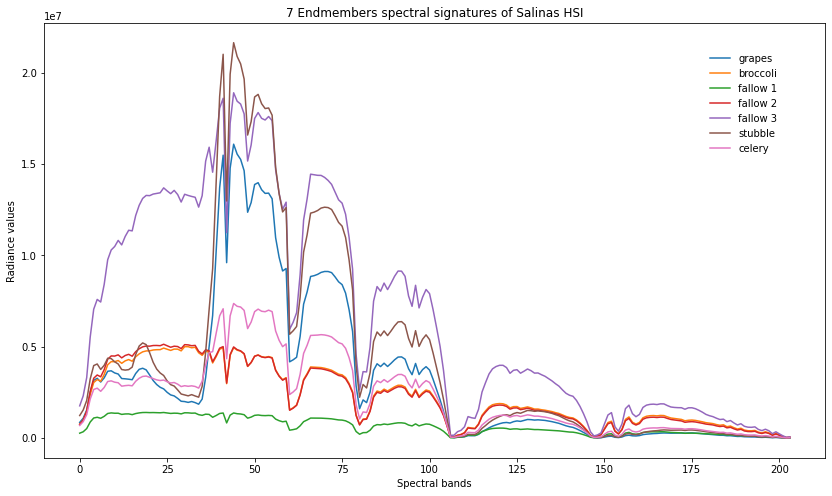

In [7]:
fig = plt.figure(figsize=(14, 8))

plt.plot(endmembers)
plt.legend(endmember_names, bbox_to_anchor=(0.95, 0.95), framealpha=0)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')

plt.show()

In [8]:
ground_truth = sio.loadmat('data/Salinas_gt.mat')

ground_truth

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 23:21:46 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_gt': array([[0, 0, 0, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [9]:
labels = ground_truth['salinas_gt']

labels.shape

(220, 120)

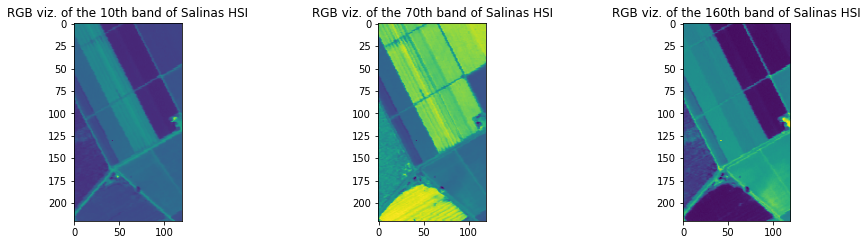

In [10]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(2,2,1)

ax.imshow(hsi[:, :, 10])
ax.set_title('RGB viz. of the 10th band of Salinas HSI')

ax = fig.add_subplot(2,3,2)

ax.imshow(hsi[:, :, 70])
ax.set_title('RGB viz. of the 70th band of Salinas HSI')

ax = fig.add_subplot(2,2,2)

ax.imshow(hsi[:, :, 160])
ax.set_title('RGB viz. of the 160th band of Salinas HSI')

plt.show()

In [11]:
salinas_labels = sio.loadmat('data/classification_labels_Salinas.mat')

salinas_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 16:49:08 2021',
 '__version__': '1.0',
 '__globals__': [],
 'operational_set': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'test_set': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'training_set': array([[0],
        [6],
        [6],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

In [12]:
training_set = (np.reshape(salinas_labels['training_set'], (120, 220))).T
test_set = (np.reshape(salinas_labels['test_set'], (120, 220))).T
operational_set = (np.reshape(salinas_labels['operational_set'], (120, 220))).T

In [13]:
training_set.shape

(220, 120)

In [14]:
test_set.shape

(220, 120)

In [15]:
operational_set.shape

(220, 120)

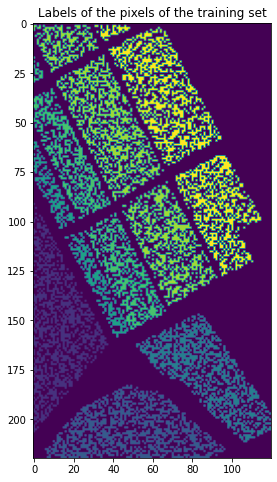

In [16]:
fig = plt.figure(figsize=(14, 8))

plt.imshow(training_set)
plt.title('Labels of the pixels of the training set')

plt.show()

# Spectral Unmixing

In this first part, our aim is to perform spectral unmixing on each one of the pixels in the image with
nonzero label, with respect to the $m = 7$ endmembers:

In [17]:
endmember_names

['grapes', 'broccoli', 'fallow 1', 'fallow 2', 'fallow 3', 'stubble', 'celery']

We adopt the **linear spectral unmixing hypothesis**:

$$ y = X \theta + \eta $$

where:

- $y$ is the $L$-dimensional spectral signature of the pixel under study
- $X$ is composed by the spectral signatures $x_1, \dots, x_m$ of the pure pixels (i.e. pure materials) in the image - they are also $L$-dimensional columns
- $\theta$ is the $m$-dimensional abundance vector of the pixel
- $\eta$ is the $L$-dimensional i.i.d., zero-mean Gaussian noise vector

We also define the reconstruction error as follows:

$$ \cfrac{1}{N} \sum_{n=1}^N \lVert y_i - X \theta_i \rVert^2 $$

**note**: in our particular problem, $N$ designates the total number of pixels in the image with non-zero label.

In [18]:
def reconstruction_error(image_cube, endmembers, labels, estimates):
    """Implements the reconstruction error.
    
    Args:
        image_cube: an (m, n, l) array.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
        estimates: an (m, n, 7) array, containing the unmixinh estimates.
    
    Returns (float):
        The reconstruction error.
    """
    m, n, _ = image_cube.shape
    
    c, error = 0, 0

    for i in range(m):

        for j in range(n):

            if labels[i][j] == 0:
                # we consider only non-zero labels
                continue
                
            error += np.sum(
                np.power(image_cube[i, j, :] - np.dot(endmembers, estimates[i, j, :]), 2)
            )
            c += 1
                
    return error / c

### (a) Least Squares, with no constraints

We will firstly approach this task via the unconstrained Least Squares method.

That is, we will solve the problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2 $$

It can be shown that: $$ \hat{\theta} = (X^TX)^{-1} X^Ty$$

We will use the Least Squares solver provided by the [numpy.linalg](https://numpy.org/doc/stable/reference/routines.linalg.html) module.

In [19]:
def unconstrained_least_squares_solver(image_cube, endmembers, labels):
    """Implements a Least Squares solver, assuming no constraints.
    
    Args:
        image_cube: an (m, n, l) array.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (m, n, 7) array.
    """
    m, n, _ = image_cube.shape
    
    theta = np.zeros((m, n, endmembers.shape[1]))  # initialize an (m, n, 7) array
    
    for i in range(m):
    
        for j in range(n):
            
            if labels[i][j] == 0:
                # we consider only non-zero labels
                continue

            # perform on (i, j) pixel
            theta[i][j] = np.linalg.lstsq(a=endmembers, b=image_cube[i][j], rcond=None)[0]
    
    return theta 

In [20]:
def abundance_maps(estimates, names=endmember_names):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 20), facecolor='w', edgecolor='k')
    
    axs = axs.ravel()

    for i, name in enumerate(names):

        axs[i].imshow(estimates[:, :, i])
        axs[i].set_title(name)
        axs[i].grid(False)

    fig.tight_layout()
    
    # remove 8th and 9th subplot entry of the 3x3 grid
    fig.delaxes(axs[-1])
    fig.delaxes(axs[-2])

Let's proceed with the calculations:

In [21]:
estimation = unconstrained_least_squares_solver(hsi, endmembers, labels)

method: unconstrained Least Squares
reconstruction error: 35058.880662772615

abundance map per endmember/material:


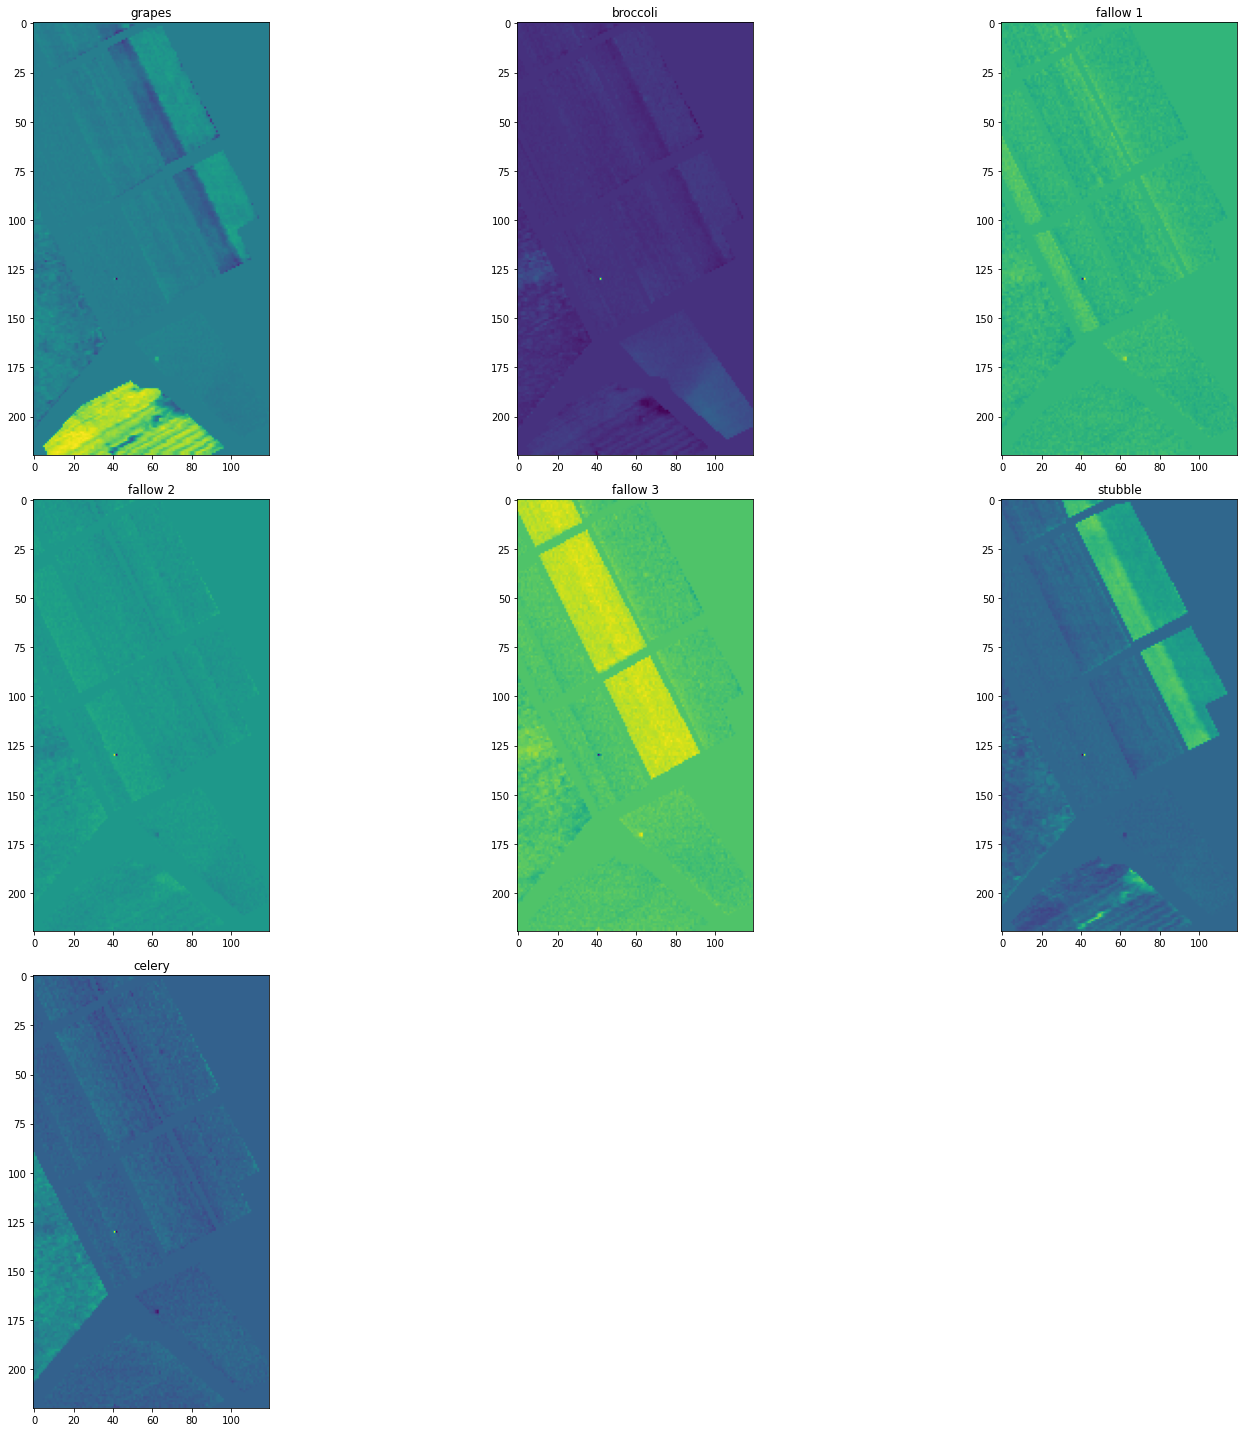

In [22]:
error1 = reconstruction_error(hsi, endmembers, labels, estimation)

print('method: unconstrained Least Squares')
print(f'reconstruction error: {error1}\n')
print('abundance map per endmember/material:')

abundance_maps(estimation)

In [23]:
def visualize_estimates(est, labels):
    
    fig = plt.figure(figsize=(14, 8))
    
    ax = fig.add_subplot(111)
    
    ax.hist(np.sum(est, axis=2)[labels != 0],
            density=True, 
            bins=30)
    
    ax.set_title('$\sum_1^7 \\theta_i$')

    plt.show()

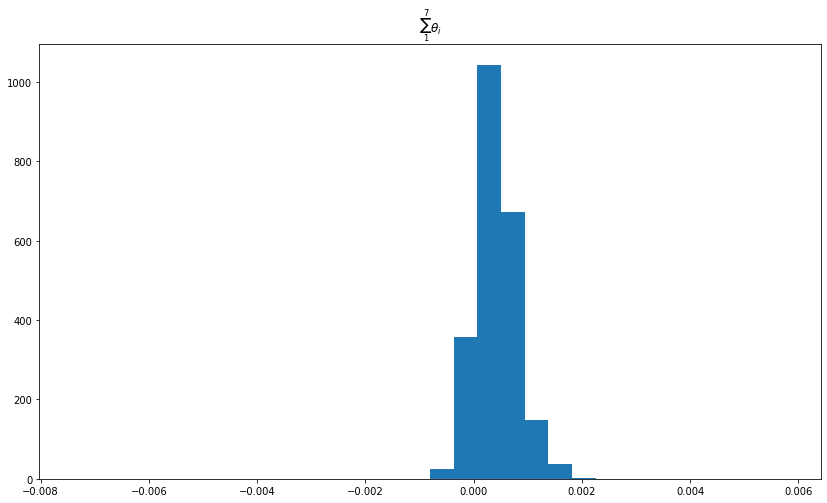

In [24]:
visualize_estimates(estimation, labels)

### (b) Least Squares, with a sum-to-one constraint

We will now include a sum-to-one constraint to our Least Squares problem:

That is, we will solve the problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \sum_{i=1}^7 \theta_i = 1$$

There are a couple of ways to subject the problem to the sum-to-one constraint. Namely:
- solve the unconstrained problem and perform suitable post-transformation to recover the under-constraint solution 
- introduce constraint as an extra problem equation, along with a weighting policy in favor of this equation, so as to "force" solution to uphold constraint.

We will proceed with the second point.

Our unconstrained Least Squares solver basically solves a set of $L$ equations. We need to incorporate the additional equation: $\sum_{i=1}^7 \theta_i = 1$ and re-solve.

At the same time, we will introduce a weighting policy to the problem (i.e. resulting in a Weighted Least Squares formulation) so as:

$$ \hat{\theta} = (X^T W X)^{-1} X^T W y$$

and also make sure that the additional equation representing the sum-to-one constrained is disproportionally weighted, compared to all the others.

In [25]:
def get_weight_matrix(image_cube):
    
    _, _, l = image_cube.shape
    
    w = np.eye(l + 1, l + 1)  # augmented by 1
    
    w[-1] = w[-1] * 5000  # disproportional weighting of last entry
    
    return w

In [26]:
def weighted_least_squares_solver(image_cube, endmembers, labels):
    """Implements a Weighted Least Squares solver, assuming no constraints.
    
    Args:
        image_cube: an (m, n, l) array.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Weighted Least Squares solution, as an (m, n, 7) array.
    """
    m, n, _ = image_cube.shape
    
    weights = get_weight_matrix(image_cube)
    
    theta = np.zeros((m, n, endmembers.shape[1]))  # initialize an (m, n, 7) array
    
    wmembers = np.vstack((endmembers, np.ones(endmembers.shape[1])))
    wmembers = np.dot(weights, wmembers)
    
    for i in range(m):
    
        for j in range(n):
            
            if labels[i][j] == 0:
                # we consider only non-zero labels
                continue
            
            augmented_pixel = np.append(image_cube[i][j], [1])
            augmented_pixel = np.dot(augmented_pixel, weights)
            # perform on (i, j) pixel
            theta[i][j] = np.linalg.lstsq(a=wmembers, b=augmented_pixel, rcond=None)[0]
    
    return theta 

In [27]:
estimation = weighted_least_squares_solver(hsi, endmembers, labels)

method: Least Squares with sum-to-one constraint
reconstruction error: 57530.52791006275

abundance map per endmember/material:


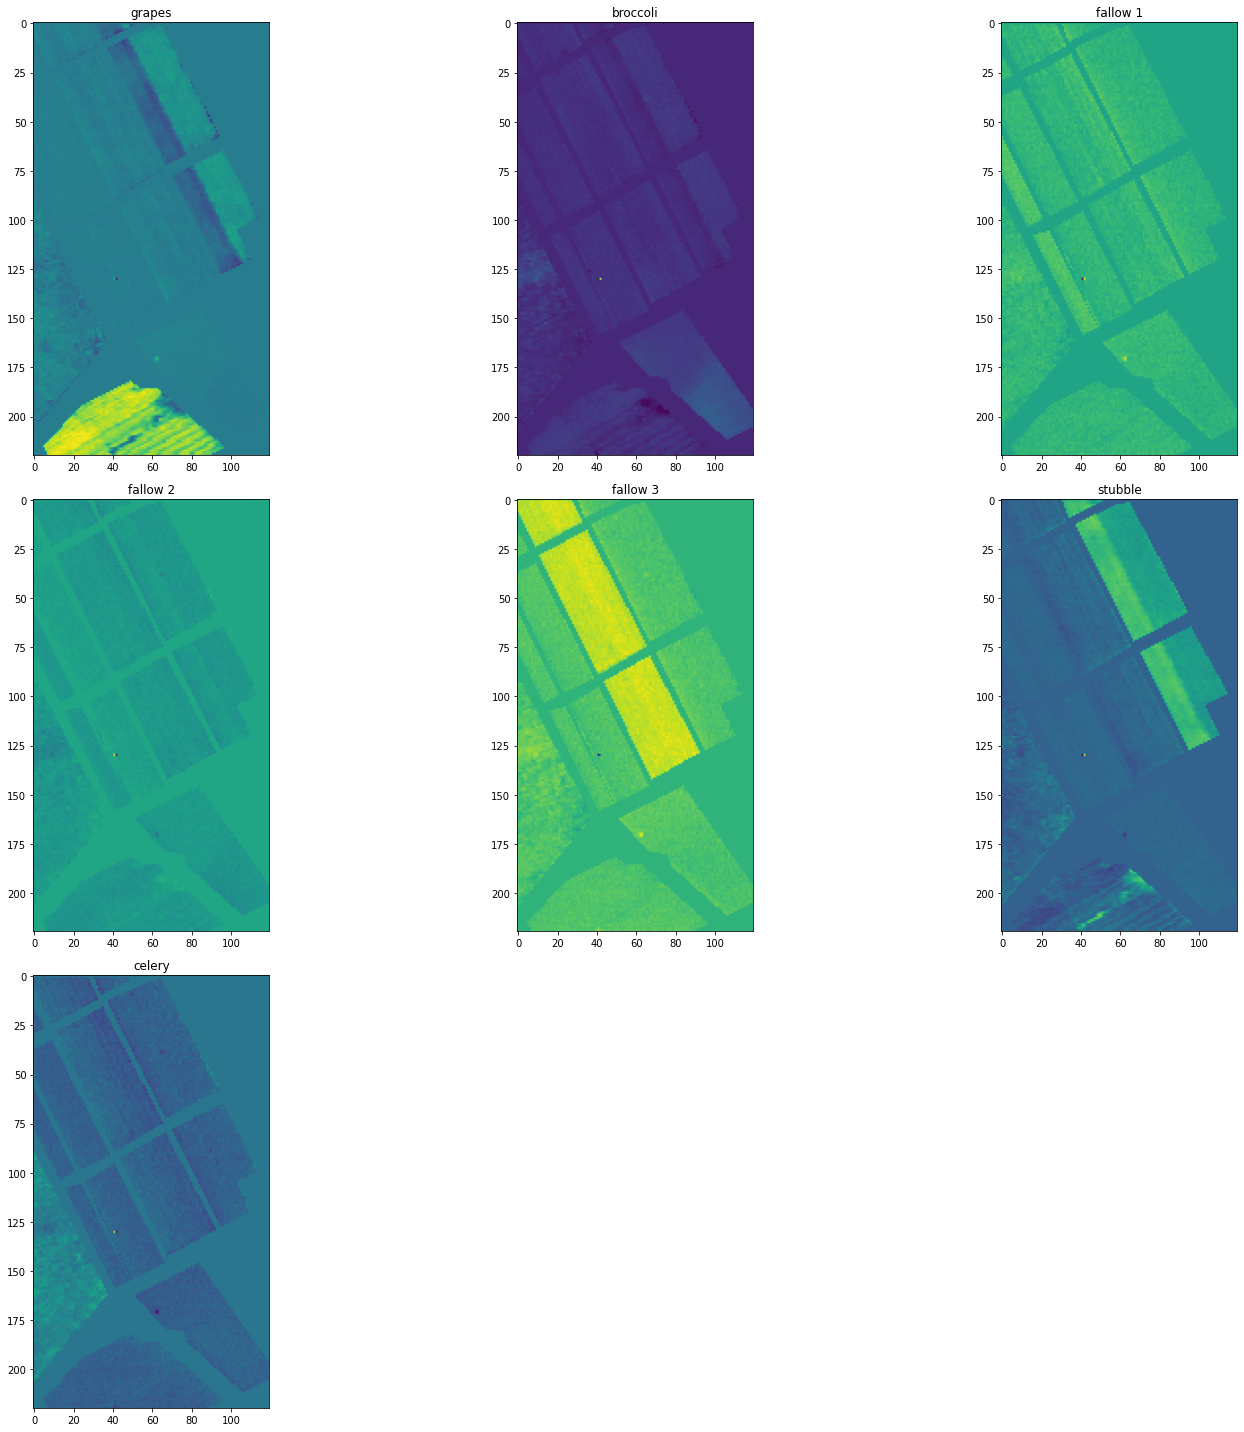

In [28]:
error2 = reconstruction_error(hsi, endmembers, labels, estimation)

print('method: Least Squares with sum-to-one constraint')
print(f'reconstruction error: {error2}\n')
print('abundance map per endmember/material:')

abundance_maps(estimation)

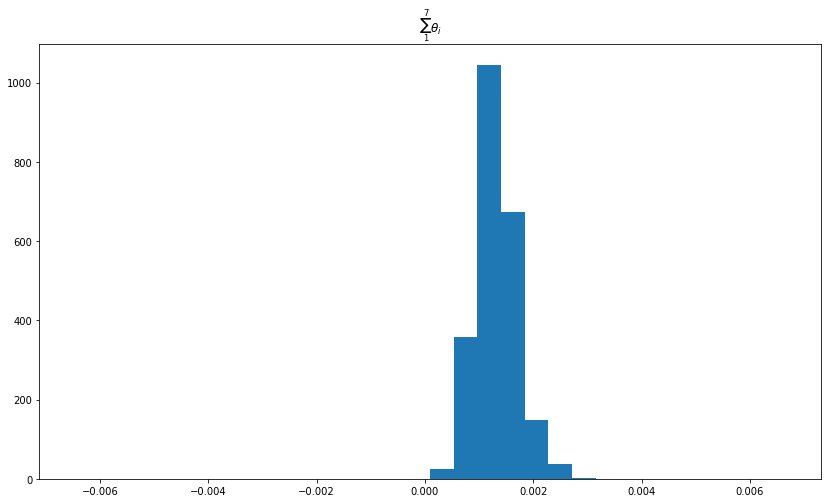

In [29]:
visualize_estimates(estimation, labels)

### (c) Least Squares, with a non-negativity constraint

We will now attempt to solve the LS problem, by introducing a non-negativity constraint:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \theta \geq 0 $$

Since this is a straightforward restriction (enforcing bounds on the values a parameter can get) we will utilize the respective open-source implementation: [scipy.optimize.nnls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html)

In [30]:
def nonnegative_least_squares_solver(image_cube, endmembers, labels):
    """Implements a Least Squares solver, assuming a non-negative constraint.
    
    Args:
        image_cube: an (m, n, l) array.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (m, n, 7) array.
    """
    m, n, _ = image_cube.shape
    
    theta = np.zeros((m, n, endmembers.shape[1]))  # initialize an (m, n, 7) array
    
    for i in range(m):
    
        for j in range(n):
            
            if labels[i][j] == 0:
                # we consider only non-zero labels
                continue

            # perform on (i, j) pixel
            theta[i][j] = scipy.optimize.nnls(A=endmembers, b=image_cube[i][j])[0]
    
    return theta 

In [31]:
estimation = nonnegative_least_squares_solver(hsi, endmembers, labels)

method: Least Squares with non-negativity constraint
reconstruction error: 156104.1822064472

abundance map per endmember/material:


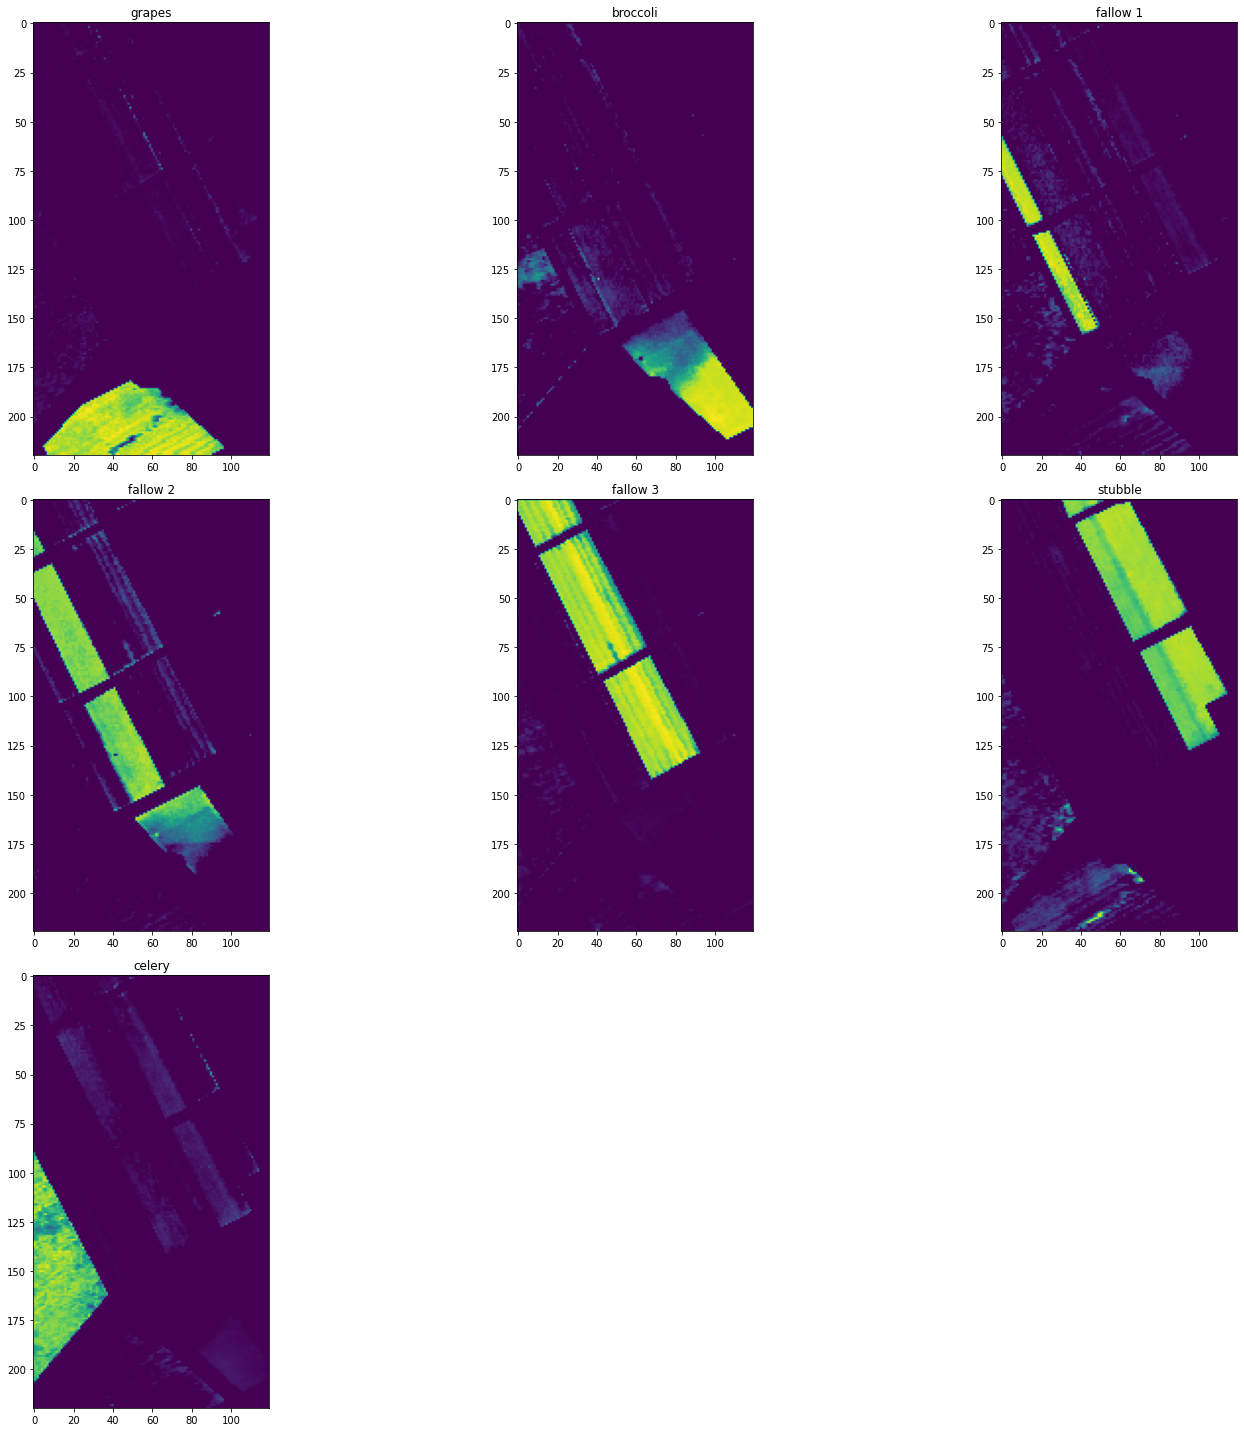

In [32]:
error3 = reconstruction_error(hsi, endmembers, labels, estimation)

print('method: Least Squares with non-negativity constraint')
print(f'reconstruction error: {error3}\n')
print('abundance map per endmember/material:')

abundance_maps(estimation)

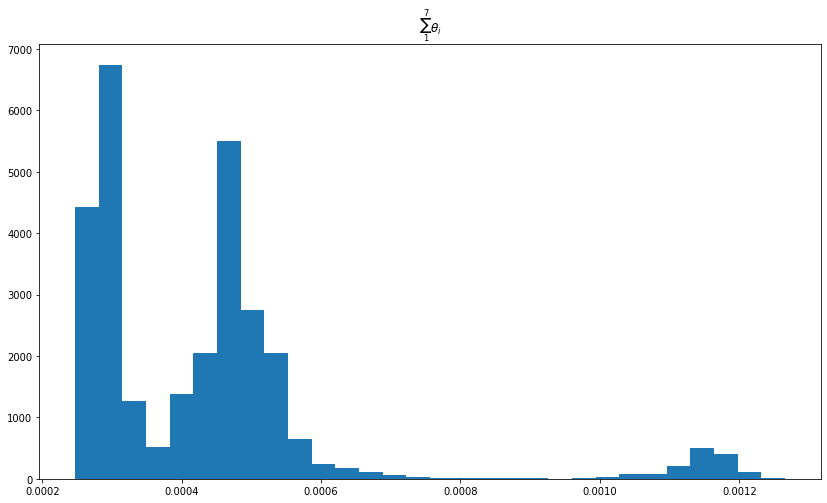

In [33]:
visualize_estimates(estimation, labels)

### (d) Least Squares, with sum-to-one & non-negativity constraints

### (e) LASSO

### Comparison and Remarks

# Classification

# Combination